In [154]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forecast as fc
import pickle
import pykrige as pkr
from lmfit import Model, Parameters

In [155]:
# loading data

provinces = pd.read_csv('..\data\dati-province\dpc-covid19-ita-province.csv')
today = '2021-06-26T17:00:00'
today_data = provinces.loc[provinces['data']==today]

population = pd.read_csv('..\data\Popolazione_province.csv', index_col=0)

p_list = pd.read_csv('..\data\Provinces_list.csv')['Sigla'].tolist()

# Load the coordinates from the file
with open('..\data\coordinates_dict.pickle', 'rb') as file:
    coord_df = pickle.load(file)

# Load the distances from the file
with open('..\data\distances_df.pickle', 'rb') as file:
    distances_df = pickle.load(file)


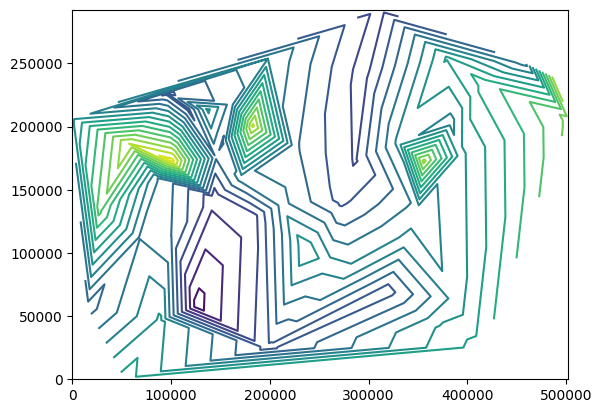

In [156]:
# Load the dictionary from the file
with open('..\data\provinces_fit.pickle', 'rb') as file:
    provinces_fitted = pickle.load(file)

selected_start=200
wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in p_list]
wave_params = [ provinces_fitted[sigla].L_waves[wave_index[i]].params  for i, sigla in enumerate(p_list)]
z1 = [param['K'].value for param in wave_params]
z2 = [param['b'].value for param in wave_params]
z3 = [param['c'].value for param in wave_params]
z4 = [param['t_max'].value for param in wave_params]

plt.figure()
plt.tricontour([coord_df[sigla][0] for sigla in p_list], [coord_df[sigla][1] for sigla in p_list], z4, levels=20, cmap='viridis')


In [157]:
# Distance matrix

D = distances_df.to_numpy()

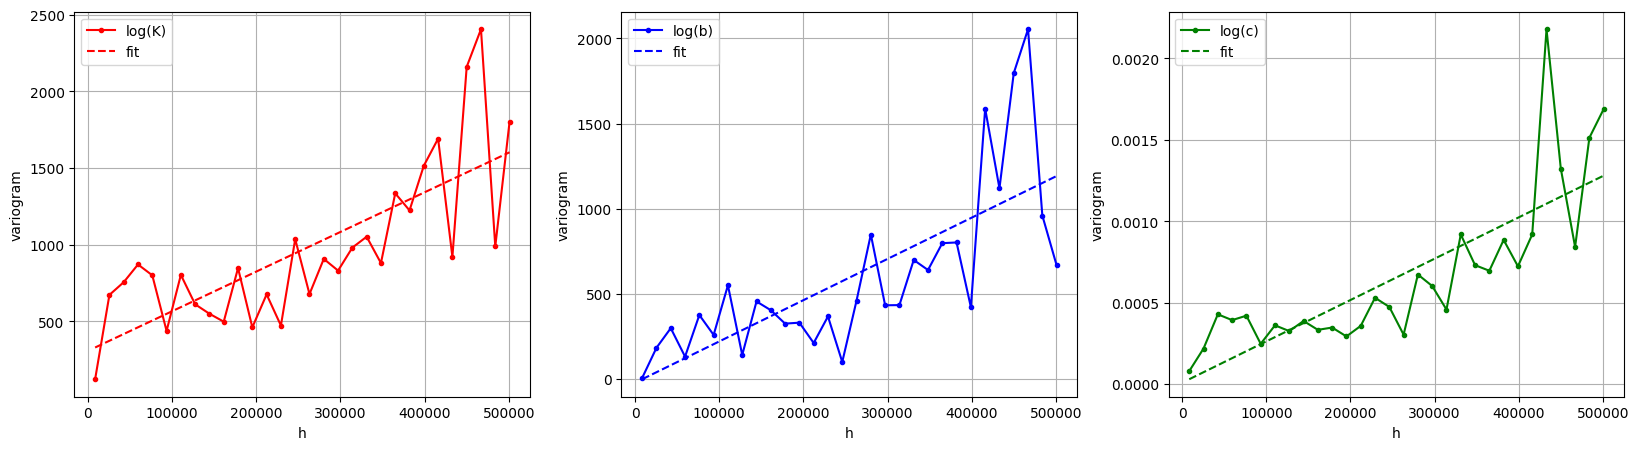

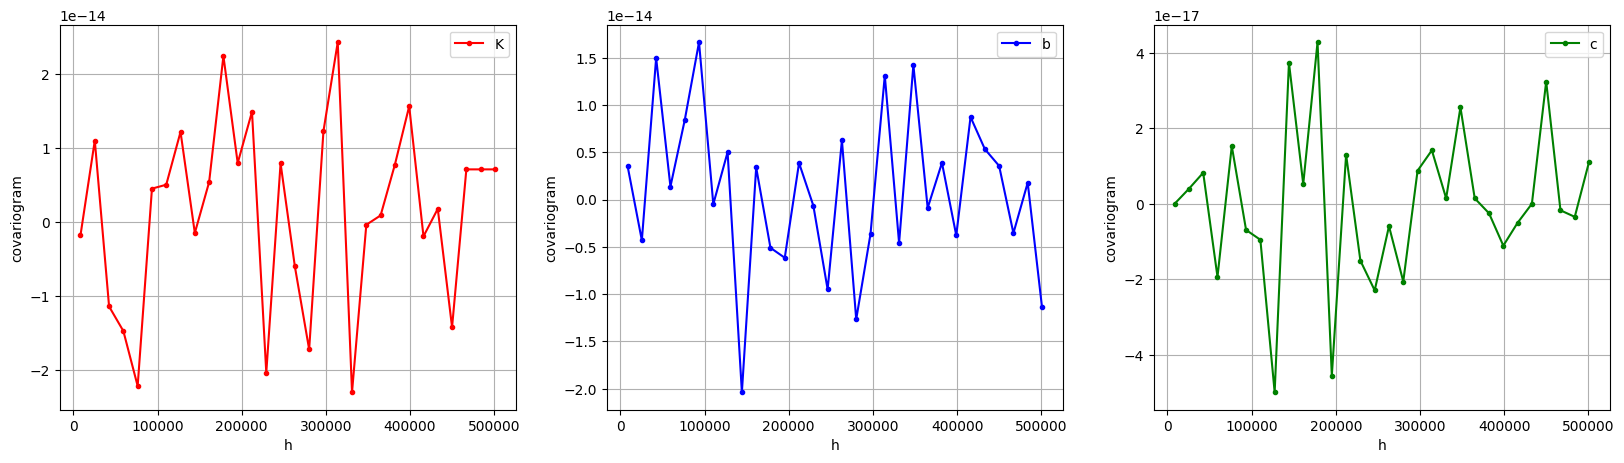

In [158]:
# Distance bins and empirical variograms and covariograms

D_max = np.amax(D)
n_points = D.shape[0]
n_bins = 30
bin_edges = np.linspace(0,D_max,n_bins+1)
bin_width = bin_edges[1]-bin_edges[0]
bin_centers = np.linspace(bin_width/2,D_max-bin_width/2, n_bins)
bins = []
for k in range(n_bins):
    bin_k = []
    for i in range(n_points):
        for j in range(i+1, n_points):
            if D[i,j]>bin_edges[k] and D[i,j]<=bin_edges[k+1]:
                bin_k.append((i,j))
    bins.append(bin_k)
            
gamma_K = np.zeros(n_bins)  # empirical variograms
gamma_b = np.zeros(n_bins)  # empirical variograms
gamma_c = np.zeros(n_bins)  # empirical variograms
C_K = np.zeros(n_bins)  # empirical covariograms
C_b = np.zeros(n_bins)  # empirical covariograms
C_c = np.zeros(n_bins)  # empirical covariograms
m_K = np.zeros(n_bins)  # empirical covariograms
m_b = np.zeros(n_bins)  # empirical covariograms
m_c = np.zeros(n_bins)  # empirical covariograms

for h in range(n_bins):     # Computation of gamma and m
    sum_K = 0
    sum_b = 0
    sum_c = 0
    var_K = 0
    var_b = 0
    var_c = 0
    for s in range(len(bins[h])):
        i = bins[h][s][0]
        j = bins[h][s][1]
        var_K += (z1[i]-z1[j])**2
        var_b += (z2[i]-z2[j])**2
        var_c += (z3[i]-z3[j])**2
        sum_K += z1[i]+z1[j]
        sum_b += z2[i]+z2[j]
        sum_c += z3[i]+z3[j]
    gamma_K[h]=1/(2*len(bins[h]))*var_K
    gamma_b[h]=1/(2*len(bins[h]))*var_b
    gamma_c[h]=1/(2*len(bins[h]))*var_c
    m_K[h]=1/(2*len(bins[h]))*sum_K
    m_b[h]=1/(2*len(bins[h]))*sum_b
    m_c[h]=1/(2*len(bins[h]))*sum_c

for h in range(n_bins):     # Computation of C
    sum_K = 0
    sum_b = 0
    sum_c = 0
    for s in range(len(bins[h])):
        i = bins[h][s][0]
        j = bins[h][s][1]
        sum_K += (z1[i]-m_K[h])+(z1[j]-m_K[h])
        sum_b += (z2[i]-m_b[h])+(z2[j]-m_b[h])
        sum_c += (z3[i]-m_c[h])+(z3[j]-m_c[h])
    C_K[h]=1/(len(bins[h]))*sum_K
    C_b[h]=1/(len(bins[h]))*sum_b
    C_c[h]=1/(len(bins[h]))*sum_c

# Fitting variograms
coefficients_K = np.polyfit(bin_centers, gamma_K, 1)
gamma_K_fit = np.polyval(coefficients_K, bin_centers)
coefficients_b = np.polyfit(bin_centers, gamma_b, 1)
gamma_b_fit = np.polyval(coefficients_b, bin_centers)
coefficients_c = np.polyfit(bin_centers, gamma_c, 1)
gamma_c_fit = np.polyval(coefficients_c, bin_centers)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(bin_centers, gamma_K, color='red', marker='.', label='log(K)')
plt.plot(bin_centers, gamma_K_fit, color='red', linestyle='--', label='fit')
plt.xlabel('h')
plt.ylabel('variogram')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(bin_centers, gamma_b, color='blue', marker='.', label='log(b)')
plt.plot(bin_centers, gamma_b_fit, color='blue', linestyle='--', label='fit')
plt.xlabel('h')
plt.ylabel('variogram')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(bin_centers, gamma_c, color='green', marker='.', label='log(c)')
plt.plot(bin_centers, gamma_c_fit, color='green', linestyle='--', label='fit')
plt.xlabel('h')
plt.ylabel('variogram')
plt.grid(True)
plt.legend()

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(bin_centers, C_K, color='red', marker='.', label='K')
plt.xlabel('h')
plt.ylabel('covariogram')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(bin_centers, C_b, color='blue', marker='.', label='b')
plt.xlabel('h')
plt.ylabel('covariogram')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(bin_centers, C_c, color='green', marker='.', label='c')
plt.xlabel('h')
plt.ylabel('covariogram')
plt.grid(True)
plt.legend()

In [159]:

test_labels = ['MO','RO', 'VI', 'AL', 'BI', 'PN', 'MB']
data_labels = [sigla for sigla in p_list if not(sigla in test_labels)]
x_data = [ coord_df[sigla][0] for sigla in (data_labels) ]
y_data = [ coord_df[sigla][1] for sigla in (data_labels) ]
x_test = [ coord_df[sigla][0] for sigla in (test_labels) ]
y_test = [ coord_df[sigla][1] for sigla in (test_labels) ]


In [160]:
selected_start=200
data_wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in data_labels]
data_wave_params = [ provinces_fitted[sigla].L_waves[data_wave_index[i]].params  for i, sigla in enumerate(data_labels)]
z1_data = [np.log(param['K'].value) for param in data_wave_params]
z2_data = [np.log(param['b'].value) for param in data_wave_params]
z3_data = [np.log(param['c'].value) for param in data_wave_params]

test_wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in test_labels]
test_wave_params = [ provinces_fitted[sigla].L_waves[test_wave_index[i]].params  for i, sigla in enumerate(test_labels)]
z1_test = [param['K'].value for param in test_wave_params]
z2_test = [param['b'].value for param in test_wave_params]
z3_test = [param['c'].value for param in test_wave_params]


Model_1 = pkr.uk.UniversalKriging(x_data,y_data,z1_data,'linear')
Model_2 = pkr.uk.UniversalKriging(x_data,y_data,z2_data,'linear')
Model_3 = pkr.uk.UniversalKriging(x_data,y_data,z3_data,'linear')

In [161]:
Z_1, S_1 = Model_1.execute('points', x_test, y_test)
Z_2, S_2 = Model_2.execute('points', x_test, y_test)
Z_3, S_3 = Model_3.execute('points', x_test, y_test)

# from log() to ()


Z_1 = np.exp(Z_1)
Z_2 = np.exp(Z_2)
Z_3 = np.exp(Z_3)

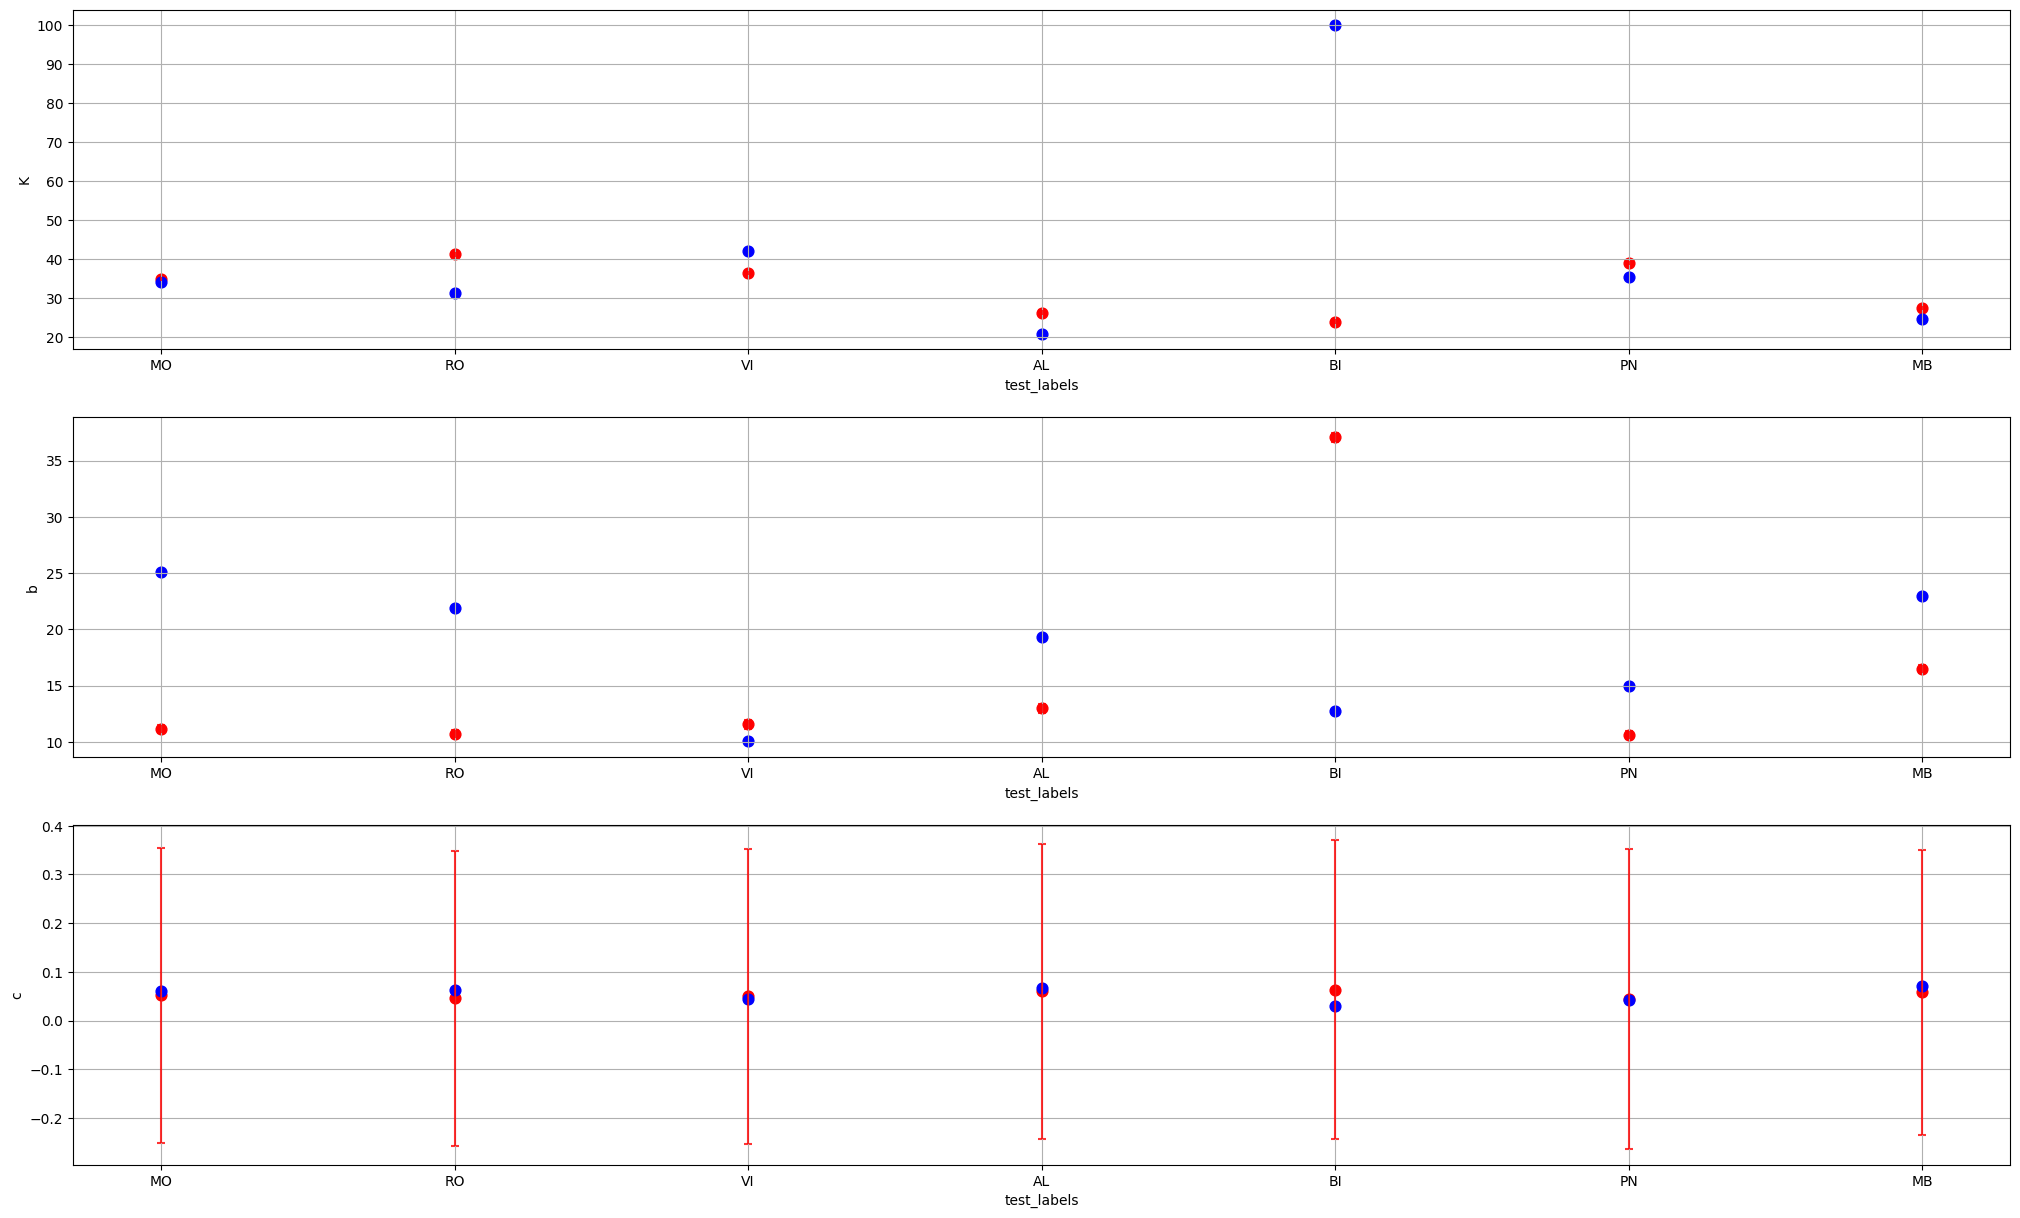

In [162]:
ms=[60]
plt.figure(figsize=(25,15))
for i,sigla in enumerate(test_labels):
    index = p_list.index(sigla)
    plt.subplot(3,1,1)
    plt.vlines(i, Z_1[i]-S_1[i]**0.5,Z_1[i]+S_1[i]**0.5, colors='red', alpha=0.8)
    plt.scatter(i,  Z_1[i]-S_1[i]**0.5, color='red', alpha=0.8, marker='_')
    plt.scatter(i,  Z_1[i]+S_1[i]**0.5, color='red', alpha=0.8, marker='_')
    plt.scatter(i, Z_1[i], color='red', sizes=ms)
    plt.scatter(i, z1[index], color='blue', sizes=ms)
    plt.xlabel('test_labels')
    plt.xticks(np.arange(0,len(test_labels)),test_labels)
    plt.ylabel('K')
    plt.grid(True)

    plt.subplot(3,1,2)
    plt.vlines(i, Z_2[i]-S_2[i]**0.5,Z_2[i]+S_2[i]**0.5, colors='red', alpha=0.8)
    plt.scatter(i,  Z_2[i]-S_2[i]**0.5, color='red', alpha=0.8, marker='_')
    plt.scatter(i,  Z_2[i]+S_2[i]**0.5, color='red', alpha=0.8, marker='_')
    plt.scatter(i, Z_2[i], color='red', sizes=ms)
    plt.scatter(i, z2[index], color='blue', sizes=ms)
    plt.xlabel('test_labels')
    plt.xticks(np.arange(0,len(test_labels)),test_labels)
    plt.ylabel('b')
    plt.grid(True)

    plt.subplot(3,1,3)
    plt.vlines(i, Z_3[i]-S_3[i]**0.5,Z_3[i]+S_3[i]**0.5, colors='red', alpha=0.8)
    plt.scatter(i,  Z_3[i]-S_3[i]**0.5, color='red', alpha=0.8, marker='_')
    plt.scatter(i,  Z_3[i]+S_3[i]**0.5, color='red', alpha=0.8, marker='_')
    plt.scatter(i, Z_3[i], color='red', sizes=ms)
    plt.scatter(i, z3[index], color='blue', sizes=ms)
    plt.xlabel('test_labels')
    plt.xticks(np.arange(0,len(test_labels)),test_labels)
    plt.ylabel('c')
    plt.grid(True)



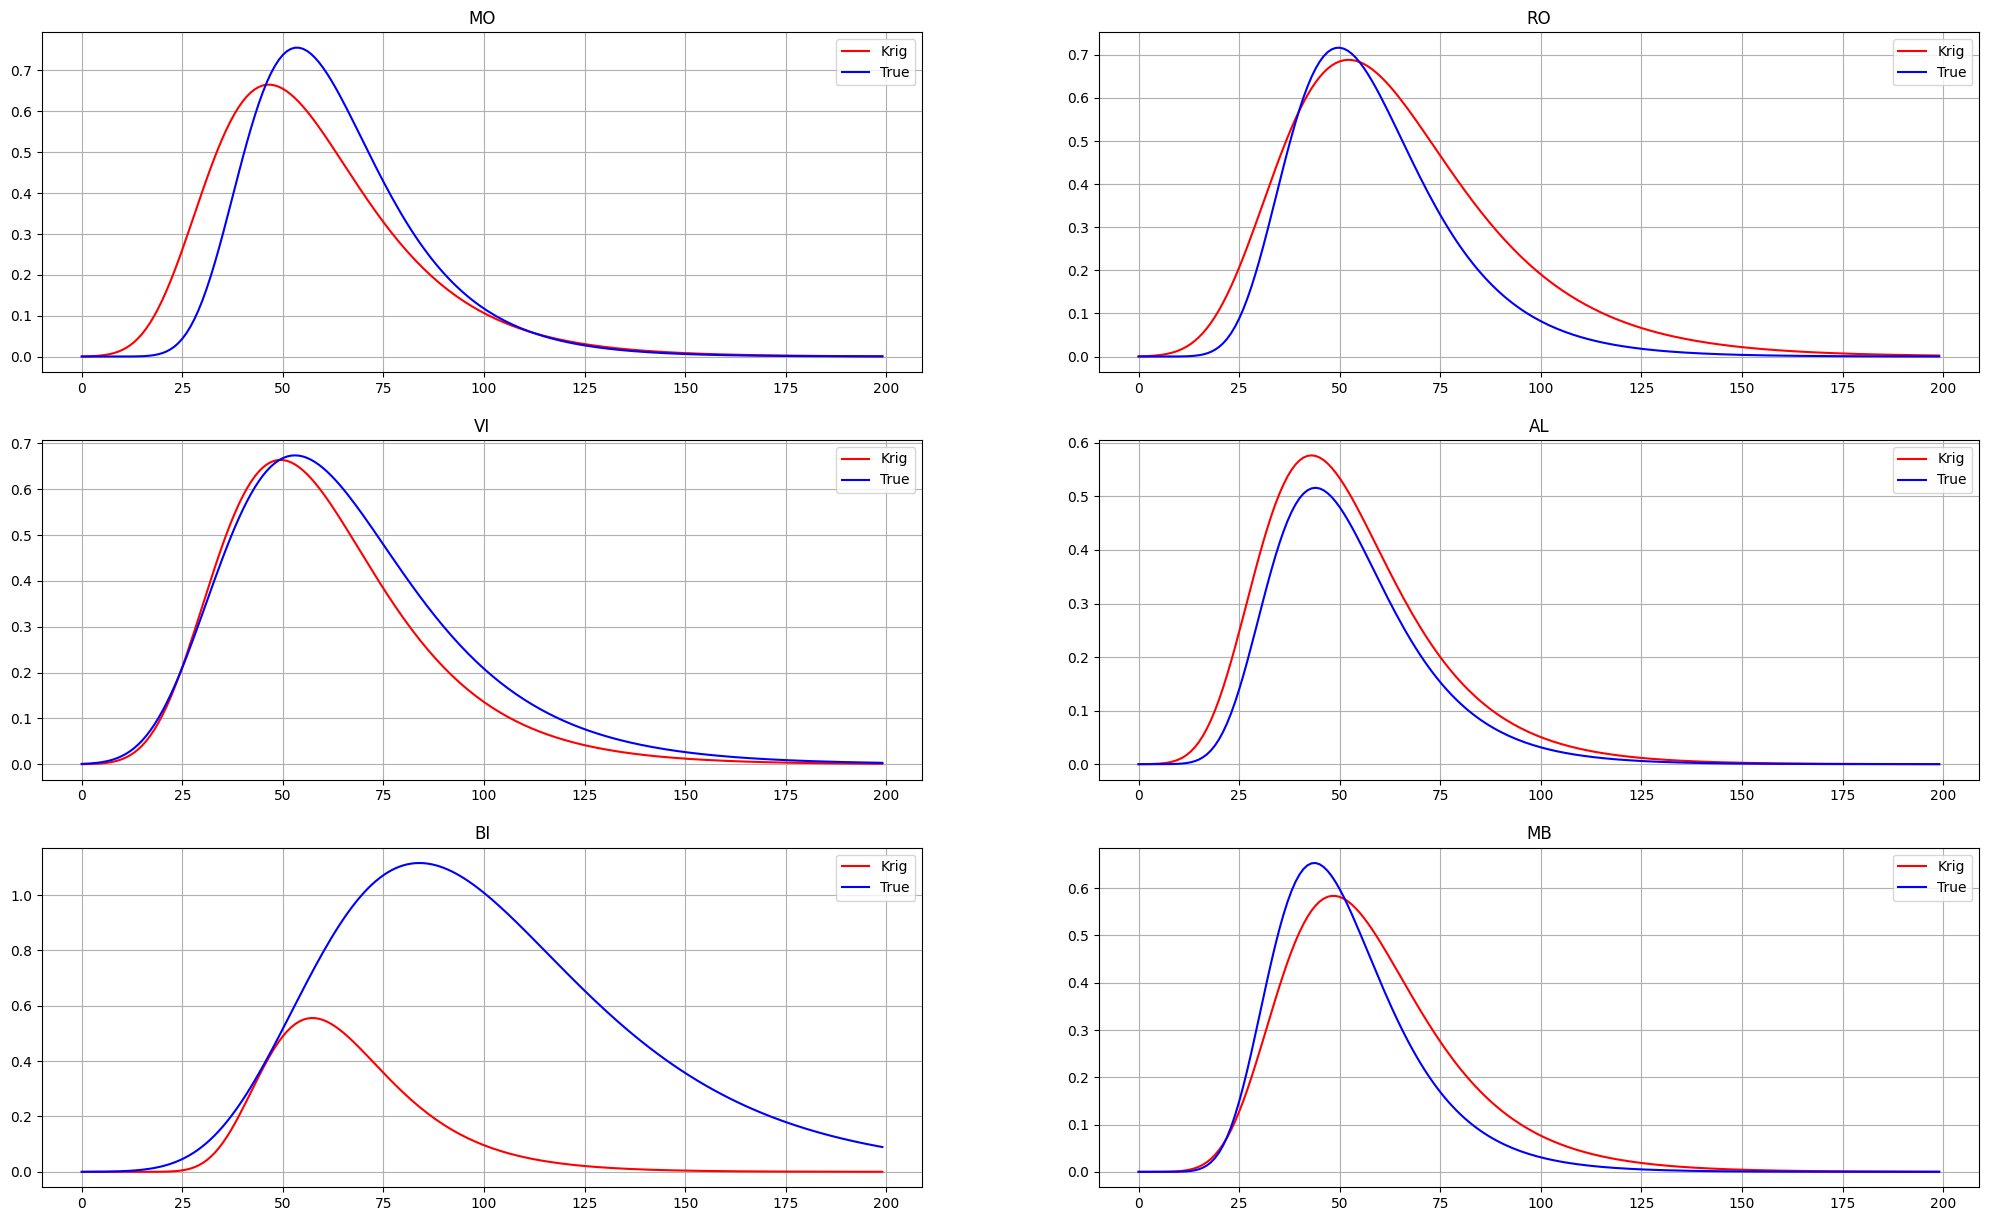

In [163]:
# Plotting curves
tt = np.arange(0,200)
plt.figure(figsize=(25,15))
j=0
for i,sigla in enumerate(test_labels):
    if not sigla=='PN':
        index = p_list.index(sigla)
        plt.subplot(3,2,j+1)
        plt.title(sigla)
        plt.grid(True)
        wave_krig = fc.gompertz(tt,Z_1[i], Z_2[i], Z_3[i])
        wave_true = fc.gompertz(tt,z1[index], z2[index], z3[index])
        plt.plot(tt,wave_krig, color='red', label='Krig')
        plt.plot(tt,wave_true, color='blue', label='True')
        plt.legend()
        j+=1



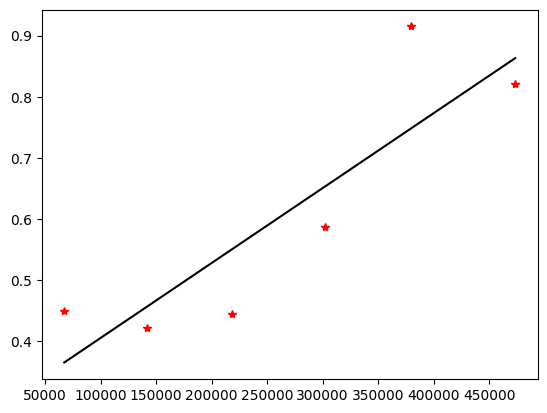

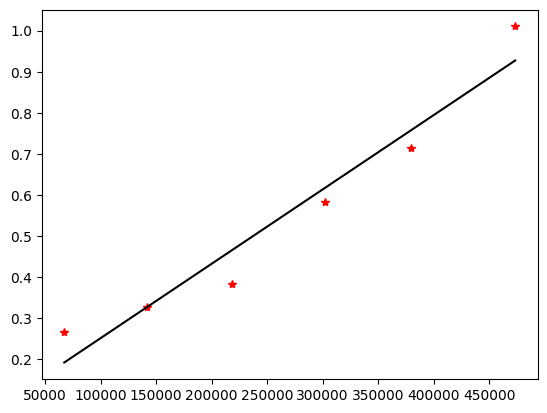

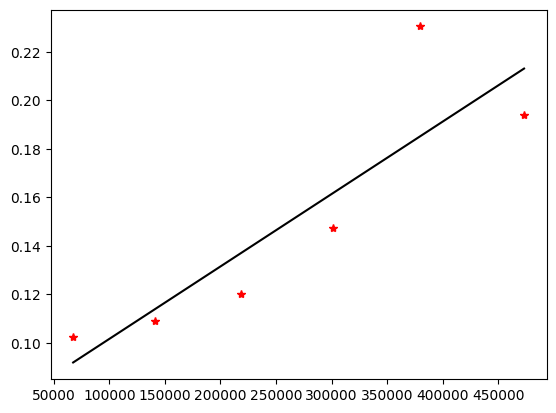

In [164]:
Model_1.display_variogram_model()
Model_2.display_variogram_model()
Model_3.display_variogram_model()

### RBF

In [ ]:
selected_start=200
data_wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in data_labels]
data_wave_params = [ provinces_fitted[sigla].L_waves[data_wave_index[i]].params  for i, sigla in enumerate(data_labels)]
z1_data = [param['K'].value for param in data_wave_params]
z2_data = [param['b'].value for param in data_wave_params]
z3_data = [param['c'].value for param in data_wave_params]

test_wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in test_labels]
test_wave_params = [ provinces_fitted[sigla].L_waves[test_wave_index[i]].params  for i, sigla in enumerate(test_labels)]
z1_test = [param['K'].value for param in test_wave_params]
z2_test = [param['b'].value for param in test_wave_params]
z3_test = [param['c'].value for param in test_wave_params]

In [165]:
# Radial basis Function approach

def RBF(z_data, coor_data, coor_test, sigma):
    n_data = len(coor_data[0])
    n_test = len(coor_test[0])

    def radial_basis(x,y,sigma):
        return 1./(1+(x**2 + y**2)/sigma**2)

    # Initial shape model
    z_m = [sum(z_data[0])/len(z_data[0]), sum(z_data[1])/len(z_data[1]), sum(z_data[2])/len(z_data[2]) ]

    S = np.zeros((n_data, n_data, 3))
    Delta = np.zeros((n_data, 3))
    W = np.zeros((n_data, 3))
    for k in range(3):
        for i in range(n_data):
            for j in range(n_data):
                S[i,j,k] = radial_basis( coor_data[0][i]-coor_data[0][j], coor_data[1][i]-coor_data[1][j], sigma[k] )

    # Compute delta
    for k in range(3):
        for i in range(n_data):
            Delta[i][k] = z1_data[i]-z_m[k]

    # Compute Weights
    for k in range(3):
        W[:,k] = np.linalg.solve(S[:,:,k],Delta[:,k])

    # Extimation in the test set
    Z_RBF = np.zeros((n_test, 3))
    for k in range(3):
        Z_RBF[:,k] = z_m[k]*np.ones(n_test)
    for k in range(3):
        for i in range(n_test):
            for j in range(n_data):
                Z_RBF[i, k] = Z_RBF[i, k] +  W[j,k]*radial_basis( coor_test[0][i] - coor_data[0][j], coor_test[1][i] - coor_data[1][j], sigma[k] )
    return Z_RBF


In [166]:
sigma = [50, 50, 50]
Z_RBF = RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma)
Z_target = np.array([z1_test, z2_test, z3_test]).T

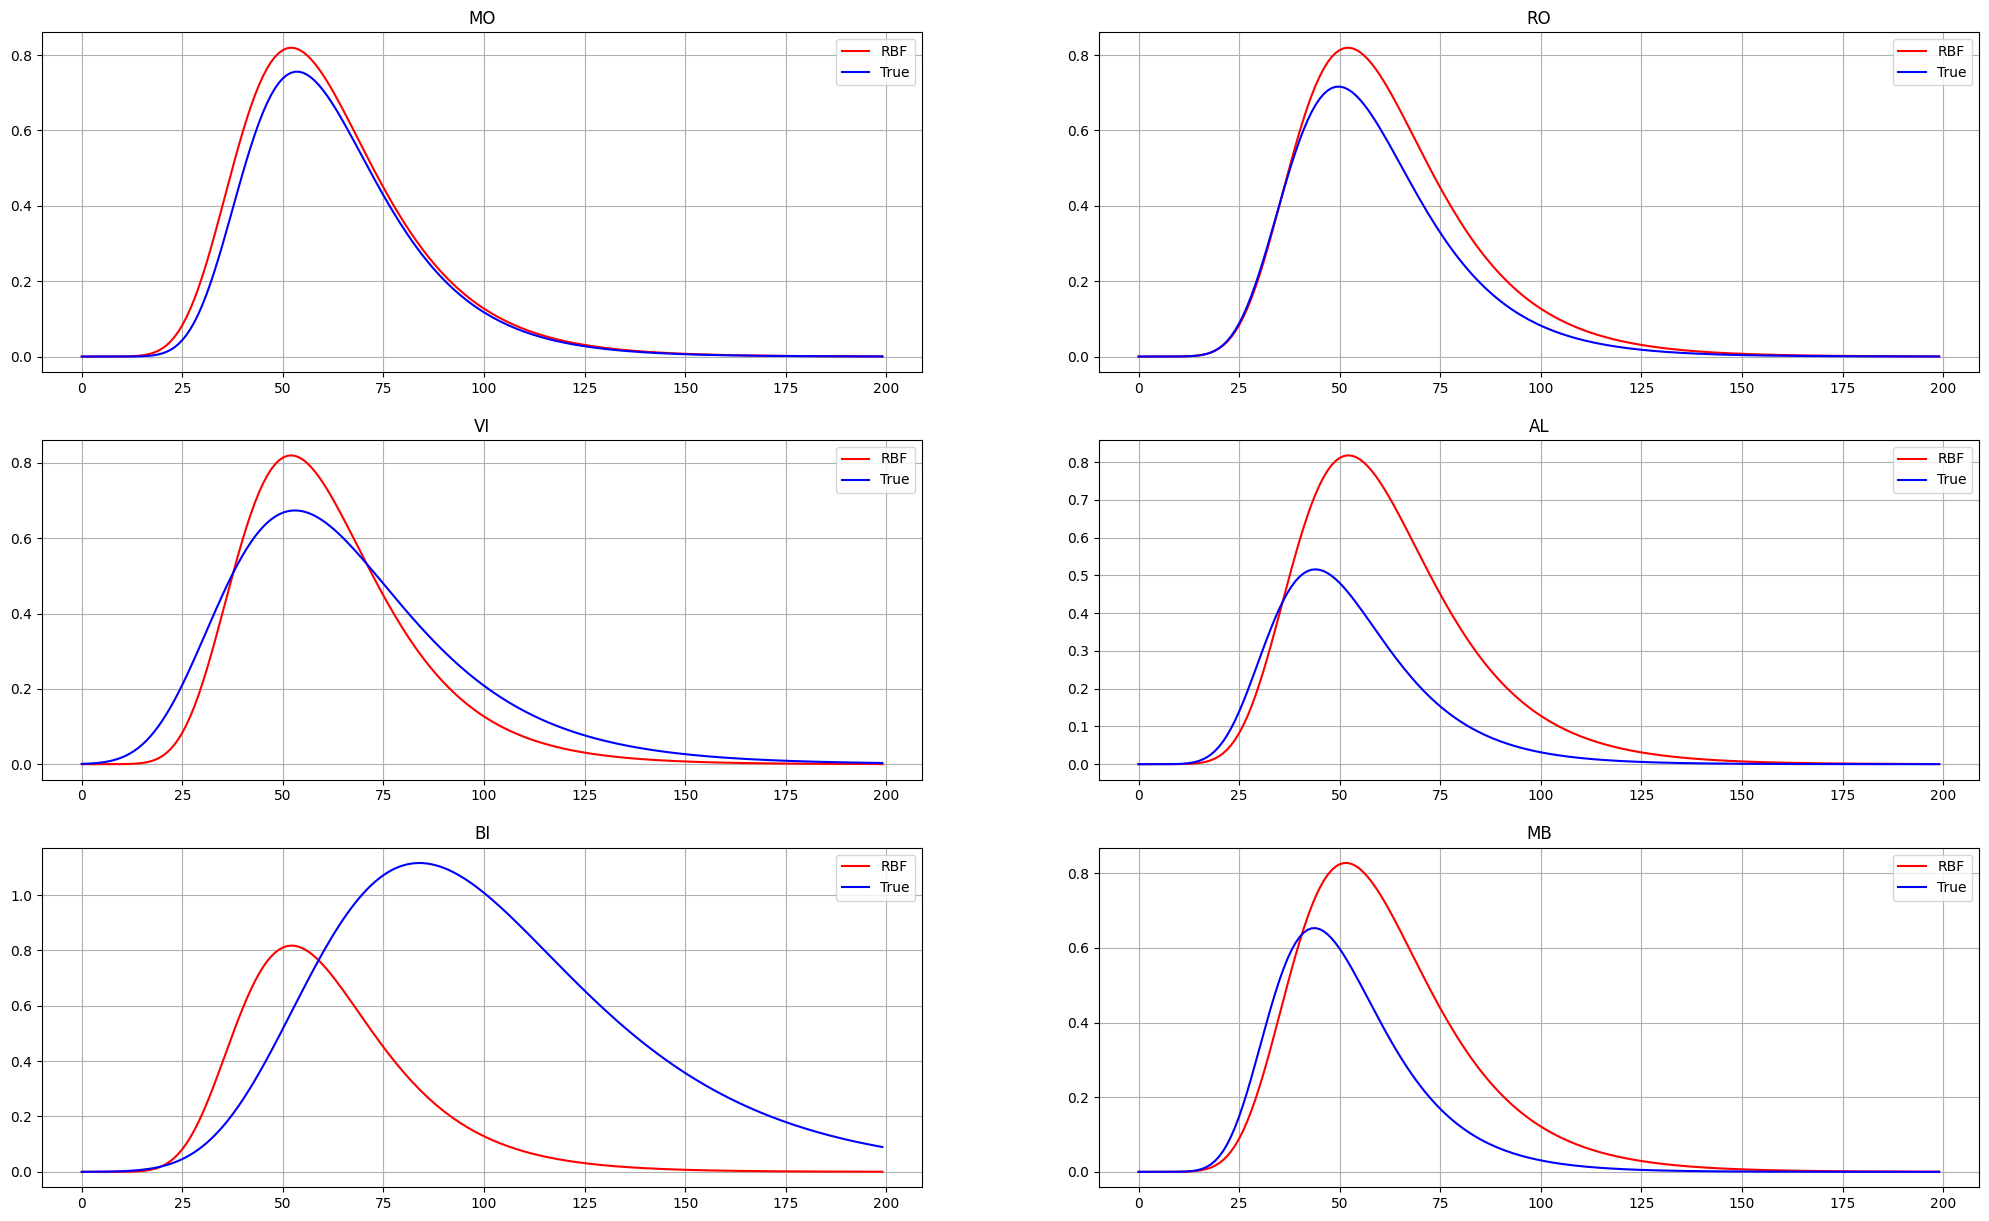

In [167]:
# Plotting curves
tt = np.arange(0,200)
plt.figure(figsize=(25,15))
j=0
for i,sigla in enumerate(test_labels):
    if not sigla=='PN':
        index = p_list.index(sigla)
        plt.subplot(3,2,j+1)
        plt.title(sigla)
        plt.grid(True)
        wave_RBF = fc.gompertz(tt,Z_RBF[i][0], Z_RBF[i][1], Z_RBF[i][2])
        wave_true = fc.gompertz(tt,z1[index], z2[index], z3[index])
        plt.plot(tt,wave_RBF, color='red', label='RBF')
        plt.plot(tt,wave_true, color='blue', label='True')
        plt.legend()
        j+=1

In [168]:
def CostFunctional(sigma, ystar, z_data, coor_data, coor_test):
    def inputOutput(sigma):
        yh = RBF(z_data, coor_data, coor_test, sigma)
        return yh
    
    # print('Evaluating Cost Functional at: ['+str(sigma[0])+','+str(sigma[1])+','+str(sigma[2])+']')
    yh = inputOutput(sigma)
    return ((ystar-yh)**2).mean(axis=None)

In [169]:
# Define a grid for Sigma
s1 = np.linspace(1,5000, 25)
s2 = np.linspace(1,5000, 25)
s3 = np.linspace(1,5000, 25)
J = 1e12

for x in s1:
    print('advancing: '+str(x/25*100)+'%')
    for y in s2:
        for z in s3:
            c = CostFunctional([x,y,z],Z_target,[z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test])
            if c < J:
                J = c
                sigma_opt = [x,y,z]

print(sigma_opt)


advancing: 0.2%
advancing: 10.2989898989899%
advancing: 20.397979797979797%
advancing: 30.4969696969697%
advancing: 40.5959595959596%
advancing: 50.69494949494949%
advancing: 60.7939393939394%
advancing: 70.8929292929293%
advancing: 80.9919191919192%
advancing: 91.0909090909091%
advancing: 101.18989898989898%


KeyboardInterrupt: 

In [ ]:

Z_RBF = RBF([z1_data, z2_data, z3_data], [x_data, y_data], [x_test, y_test], sigma_opt)
for i,sigla in enumerate(test_labels):
    index = p_list.index(sigla)
    plt.subplot(7,1,j+1)
    plt.title(sigla)
    plt.grid(True)
    wave_RBF = fc.gompertz(tt,Z_RBF[i][0], Z_RBF[i][1], Z_RBF[i][2])
    wave_true = fc.gompertz(tt,z1[index], z2[index], z3[index])
    plt.plot(tt,wave_RBF, color='red', label='RBF')
    plt.plot(tt,wave_true, color='blue', label='True')
    plt.legend()
    j+=1